# Molecular fragments
Developed for the X-ray coincidence spectroscopy purposes.
This class reads a molecular structure in SMILES format (with all explicit H atoms), and returns the list of all possible molecular fragments with their masses. 
All masses are considered whole number (e.g., I is 127, not 126.9). Also, isotopes are not taken into account (e.g., Br is just 80, not 79&81 pair) as well as multiply ionised fragments.

In [58]:
class Molecule:
    ''' Class represents molecular structure from SMILES
    notation, returns list of atoms and bonds as nodes and edges
    Calculates all possible fragments of the molecule after its decomposition keeping the same skeleton
    (no reordering of atoms considered) and the corresponding masses.
    '''
    def __init__(self, smiles):
        self._atoms = []
        self._bonds = []
        # Can be atomic number Z; here usef for ordering atoms in the formula - to start with C, H first than followed by N, O etc.
        self.Z_ = {'N': 3, 'C': 1, 'O': 4, 'H': 2, 'S': 10, 'F': 21, 'Cl': 22, 'Br': 23, 'I': 24} 
        self.A_ = {v: k for k, v in self.Z_.items()}
        self.M_ = {'H':1, 'O': 16, 'N': 14, 'C': 12, 'Br': 80, 'I': 127, 'Cl': 35, 'S': 32, 'F': 19}
        self.num_cycles = 0
        self.read_smiles(smiles)
        self._fragments = None
        
    def read_smiles(self, smiles):
        ''' Reads the smiles notation into list of nodes and links'''
        current_atom = smiles[0]
        symbols = []
        
        for char in smiles[1:]:
            if char == '(':
                symbols.append(current_atom)
                current_atom = ''
                symbols.append(char)
            elif char == ')':
                symbols.append(current_atom)
                current_atom = ''
                symbols.append(char)
            else:
                if char.lower() == char or char in '123456789':
                    current_atom += char
                    if char in '1233456789':
                        self.num_cycles = max(int(char), self.num_cycles)
                else:
                    symbols.append(current_atom)
                    current_atom = char
        symbols.append(current_atom)
        smiles2 = [sym for sym in symbols if sym != '']
        first = 0
        stack = []
        ind = 0
        a = [smiles2[0]]
        b = []
        for s in smiles2[1:]:
            if s == '(':
                stack.append(first)
            elif s == ')':
                first = stack.pop()
            else:
                ind += 1
                second = ind
                b.append((first, second))
                a.append(s)
                first = second
        for i in range(self.num_cycles):
            b1 = [k for k in range(len(a)) if a[k].endswith(str(i+1))]
            if len(b1) > 0:
                b.append((b1[0], b1[1]))
                a[b1[0]] = a[b1[0]][:-1] # remove 1s from the end of atom notation
                a[b1[1]] = a[b1[1]][:-1]
        self._atoms = a
        self._bonds = b
        if all(i in self.M_.keys() for i in self._atoms):
            self._masses = [self.M_[i] for i in self._atoms]
        else:
            print('Not all atoms are known: ')
            print([i for i in self._atoms if i not in self.M_.keys()])
    
    @classmethod
    def check_smiles(cls, smiles):
        stack = []
        for ch in smiles:
            if ch == '(':
                stack.append(')')
            elif ch == ')':
                try:
                    stack.pop()
                except IndexError:
                    return 'Non consistent ()'
        if len(stack) != 0:
            return 'Non consistent'

    @property
    def atoms(self):
        return self._atoms
    
    @property
    def bonds(self):
        return self._bonds
    
    @classmethod
    def find_fragments(cls, b, start):
        ''' Returns the nodes tree starting from *start* for the given set of bonds (*b*)
        '''
        bonds = b.copy()
        atoms = [start]
        added = True
        while added and len(bonds) > 0:
            #print(atoms, bonds)
            for ind, bond in enumerate(bonds):
                added = False
                if bond[0] in atoms:
                    if not bond[1] in atoms:
                        atoms.append(bond[1])
                        added = True
                        bonds.pop(ind)
                elif bond[1] in atoms:
                    if not bond[0] in atoms:
                        atoms.append(bond[0])
                        added = True
                    bonds.pop(ind)
                if added:
                    break
        atoms.sort()
        return atoms
    
    @classmethod
    def formula(cls, f):
        ''' Converts ordered list of atoms into a brief form with occurences, e.h. CCHHHHHH -> C2H6
        '''
        s = f[0]
        n = 0
        out = ''
        for i in f:
            if i == s:
                n += 1
            else:
                if n == 1:
                    out += s
                else:
                    out += s + str(n)
                s = i
                n = 1
        if n == 1:
            out += s
        else:
            out += s + str(n)
        return out
    
    @classmethod
    def formula_latex(cls, f):
        ''' Converts ordered list of atoms into a brief form with latex formatting, e.h. CCHHHHHH -> C$_2$H$_6^{+}$
        '''
        s = f[0]
        n = 0
        out = r''
        for i in f:
            if i == s:
                n += 1
            else:
                if n == 1:
                    out += s
                else:
                    out += s + rf'$_{n}$'
                s = i
                n = 1
        if n == 1:
            out += s
        else:
            out += s + rf'$_{n}$'
        if out[-1] == '$':
            return out[:-1] + r'^{+}$'
        else:
            return out + r'$^{+}$'
    
    def fragments(self, latex=False):
        ''' Returns a dictionary with all fragments from the molecule.'''
        if self._fragments is None:
            self.get_all_fragments()
        if latex:
            return {k: [(self.formula(frag), self.formula_latex(frag)) for frag in v] for k, v in self._fragments.items()} #remove empty entries
        else:
            return {k: [self.formula(frag) for frag in v] for k, v in self._fragments.items()} #remove empty entries
    
    def get_all_fragments(self):
        ''' Calculates all possible fragments of the molecules as a dict with corresponding masses'''
        # Generate 2^N subsets 
        L = list(range(len(self._bonds)))
        P = [[]]
        for e in L:
            P += [sub + [e] for sub in P]
        # for each subset of 'broken' bonds calculate the fragments
        FRAGMENTS = []
        LB = len(self._bonds)
        for p in P:
            if len(p):
                removed = [self.bonds[i] for i in range(LB) if i in p]
                remaining = [self.bonds[i] for i in range(LB) if not i in p]
                at = ()
                for rem in removed:
                    at += rem
                at = set(at)
                for at_ in at:
                    fr = self.find_fragments(remaining, at_)
                    if not fr in FRAGMENTS:
                        FRAGMENTS.append(fr)
            else:
                fr = self.find_fragments(self.bonds, self.bonds[0][0])
                if not fr in FRAGMENTS:
                    FRAGMENTS.append(fr)
        w = {i: [] for i in range(1, sum(self._masses)+1)}
        for f in FRAGMENTS:
            mass = sum([self._masses[i] for i in f])
            atoms_ = [self._atoms[i] for i in f]
            z_ = [self.Z_[i] for i in atoms_]
            z_.sort()
            atoms_ = [self.A_[i] for i in z_]
            mol = ''.join(atoms_)
            if mass in w.keys():
                if not mol in w[mass]:
                    w[mass].append(mol)
            else:
                w[mass] = [mol]
        self._fragments = {k: v for k, v in w.items() if v}
    
    def get_fragment(self, mass, latex=False):
        ''' Returns the list of fragments for the given mass, in plain and LaTeX format.'''
        if self._fragments is None:
            self.get_all_fragments()
        if latex:
            return [(self.formula(frag), self.formula_latex(frag)) for frag in self._fragments[mass] if mass in self._fragments.keys()]
        else:
            return [self.formula(frag) for frag in self._fragments[mass] if mass in self._fragments.keys()]

    def _get_fragment(self, mass, latex=False):
        ''' Same as get_fragment which accepts iterable list of given masses '''
        if self._fragments is None:
            self.get_all_fragments()
        if not hasattr(mass, '__iter__'): # if m is iterable, e.g. a list
            mass = [mass]
        if latex:
            return {m : [(self.formula(frag), self.formula_latex(frag)) for frag in self._fragments[m]] if m in self._fragments.keys() else None for m in mass}
        else:
            return {m: [self.formula(frag) for frag in self._fragments[m]] if m in self._fragments.keys() else None for m in mass}


## Example

In [59]:
name = "5-bromo-5'-iodo-2,2'-dithiophene"
smiles = 'BrC1SC(C(H)C1(H))C2SC(I)C(H)C2(H)'  # note explicitly given hydrogens

In [60]:
# read the molecular structure
m = Molecule(smiles)

In [61]:
m.atoms # list of atoms

['Br',
 'C',
 'S',
 'C',
 'C',
 'H',
 'C',
 'H',
 'C',
 'S',
 'C',
 'I',
 'C',
 'H',
 'C',
 'H']

In [62]:
m.bonds # list of bonds

[(0, 1),
 (1, 2),
 (2, 3),
 (3, 4),
 (4, 5),
 (4, 6),
 (6, 7),
 (3, 8),
 (8, 9),
 (9, 10),
 (10, 11),
 (10, 12),
 (12, 13),
 (12, 14),
 (14, 15),
 (1, 6),
 (8, 14)]

In [63]:
# All fragments
m.fragments()

{1: ['H'],
 12: ['C'],
 13: ['CH'],
 24: ['C2'],
 25: ['C2H'],
 26: ['C2H2'],
 32: ['S'],
 36: ['C3'],
 37: ['C3H'],
 38: ['C3H2'],
 44: ['CS'],
 48: ['C4'],
 49: ['C4H'],
 50: ['C4H2'],
 56: ['C2S'],
 57: ['C2HS'],
 60: ['C5'],
 61: ['C5H'],
 62: ['C5H2'],
 63: ['C5H3'],
 68: ['C3S'],
 69: ['C3HS'],
 70: ['C3H2S'],
 72: ['C6'],
 73: ['C6H'],
 74: ['C6H2'],
 75: ['C6H3'],
 76: ['C6H4'],
 80: ['Br', 'C4S'],
 81: ['C4HS'],
 82: ['C4H2S'],
 84: ['C7'],
 85: ['C7H'],
 86: ['C7H2'],
 87: ['C7H3'],
 88: ['C7H4', 'C2S2'],
 92: ['C5S', 'CBr'],
 93: ['C5HS'],
 94: ['C5H2S'],
 95: ['C5H3S'],
 96: ['C8'],
 97: ['C8H'],
 98: ['C8H2'],
 99: ['C8H3'],
 100: ['C8H4', 'C3S2'],
 101: ['C3HS2'],
 104: ['C2Br', 'C6S'],
 105: ['C2HBr', 'C6HS'],
 106: ['C6H2S'],
 107: ['C6H3S'],
 108: ['C6H4S'],
 112: ['C4S2'],
 113: ['C4HS2'],
 114: ['C4H2S2'],
 116: ['C3Br', 'C7S'],
 117: ['C3HBr', 'C7HS'],
 118: ['C3H2Br', 'C7H2S'],
 119: ['C7H3S'],
 120: ['C7H4S'],
 124: ['C5S2', 'CSBr'],
 125: ['C5HS2'],
 126: ['C5H2S

In [64]:
# get fragment(s) with a given mass
m.get_fragment(200)

['C7H4SBr', 'C6HI']

In [65]:
# get fragment(s) with a given mass also with a LaTeX notation, e.g. for placing them on the Matplotlib figure.
m.get_fragment(88, latex=True)

[('C7H4', 'C$_7$H$_4^{+}$'), ('C2S2', 'C$_2$S$_2^{+}$')]

In [66]:
from IPython.display import display, Latex

In [67]:
for f1, f2 in m.get_fragment(100, latex=True):
    display(Latex(f2))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Text(0.5, 0.8, 'C$_3$S$_2^{+}$')

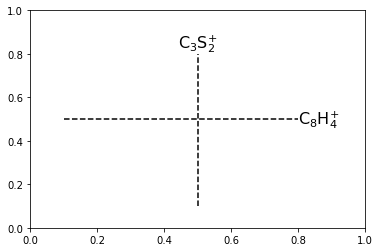

In [68]:
import matplotlib.pyplot as plt
frag = m.get_fragment(100, latex=True)
plt.figure()
plt.plot([0.1,0.8], [0.5,0.5], 'k--')
plt.plot([0.5,0.5], [0.1,0.8], 'k--')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.text(0.8, 0.5, frag[0][1], va='center', fontsize=16)
plt.text(0.5, 0.8, frag[1][1], ha='center', va='bottom', fontsize=16)

## Extras: save to xls

In [69]:
import pandas as pd

In [70]:
f_ = {str(k): ', '.join(v) for k, v in m.fragments().items()}

In [71]:
df = pd.DataFrame({'Masses': f_.keys(), 'Fragments': f_.values()})

In [72]:
df

,Masses,Fragments
0,1,H
1,12,C
2,13,CH
3,24,C2
4,25,C2H
...,...,...
207,367,C8S2BrI
208,368,C8HS2BrI
209,369,C8H2S2BrI
210,370,C8H3S2BrI


In [150]:
df.to_csv(f'{name}.csv', index=False)

In [154]:
df.to_excel(f'{name}.xlsx', index=False)